In [1]:
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import neurokit2 as nk

In [2]:
import fathon
from fathon import fathonUtils as fu

In [3]:
plt.style.use('classic')
plt.rcParams.update({'legend.fontsize': 26})
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams["figure.facecolor"] = 'white'
plt.rcParams['font.size'] = '26'
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['savefig.dpi'] = 300

## Зчитування з Yahoo Finance!

In [43]:
name_1 = "^GSPC"
data_1 = yf.download(name_1, start='2008-07-04')
time_ser_1 = data_1['Adj Close']
np.savetxt(f'{name_1}_initial_time_series.txt', time_ser_1.values)

[*********************100%***********************]  1 of 1 completed


In [44]:
name_2 = "^GSPC"
data_2 = yf.download(name_2, start='2008-07-04')
time_ser_2 = data_2['Adj Close']
for_graph = pd.Series(time_ser_2)

[*********************100%***********************]  1 of 1 completed


## Зчитування з .txt файлів

In [14]:
name_1 = "sMpa11.txt" #назва файлу 1, що зчитуємо

In [15]:
with open(name_1, 'r') as f1: #зчитуємо файл
    time_ser_1 = [line.strip('\n') for line in f1.readlines()]
    time_ser_1 = [float(line) for line in time_ser_1 if line != '']
time_ser_1 = pd.Series(time_ser_1) #перетворюємо на масив pandas для використання вбудованих функцій знаходження приб., видалення нульових значень

In [16]:
name_2 = "sMpa11.txt" #для графіки

In [17]:
with open(name_2, 'r') as f2: #зчитуємо файл
    time_ser_2 = [line.strip('\n') for line in f2.readlines()]
    time_ser_2 = [float(line) for line in time_ser_2 if line != '']
for_graph = pd.Series(time_ser_2) #перетворюємо на масив pandas для використання вбудованих функцій знаходження приб., видалення нульових значень

### Збереженяя ряду (логарифмічних) прибутковостей 

In [45]:
log_ret = (np.log(time_ser_1) - np.log(time_ser_1.shift(1))).dropna()
log_ret -= log_ret.mean()
log_ret /= log_ret.std()

pct_change = time_ser_1.pct_change().dropna()
pct_change -= pct_change.mean()
pct_change /= pct_change.std()

np.savetxt(f'{name_1}_log_ret.txt', log_ret)
np.savetxt(f'{name_1}_pct_change.txt', pct_change)

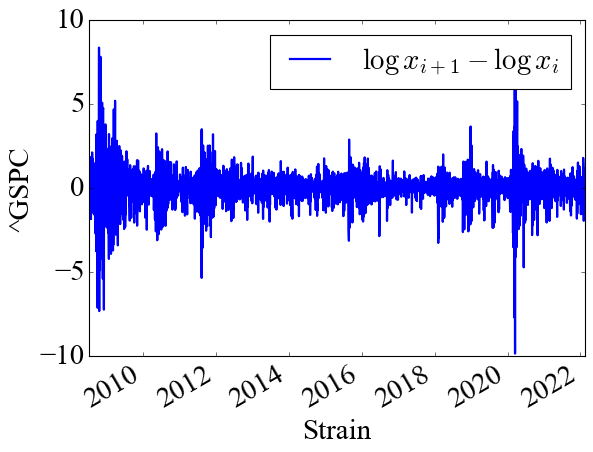

In [46]:
log_ret.plot(figsize=(8,6), xlabel='Strain', ylabel=fr"{name_1.split('.')[0]}", label=r"$\log{x_{i+1}} - \log{x_{i}}$")
plt.legend()
plt.savefig('ts1_log_ret.jpg', bbox_inches="tight")
plt.show()

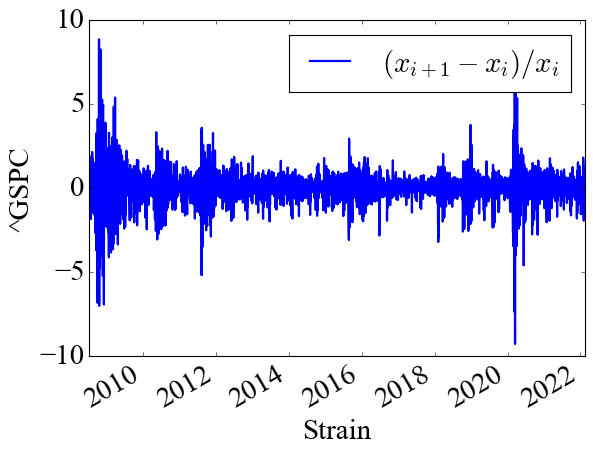

In [47]:
pct_change.plot(figsize=(8,6), xlabel='Strain', ylabel=fr"{name_1.split('.')[0]}", label=r"$(x_{i+1} - x_{i})/x_{i}$")
plt.legend()
plt.savefig('ts1_simple_ret.jpg', bbox_inches="tight")
plt.show()

## Виведення графіку досліджуваного ряду

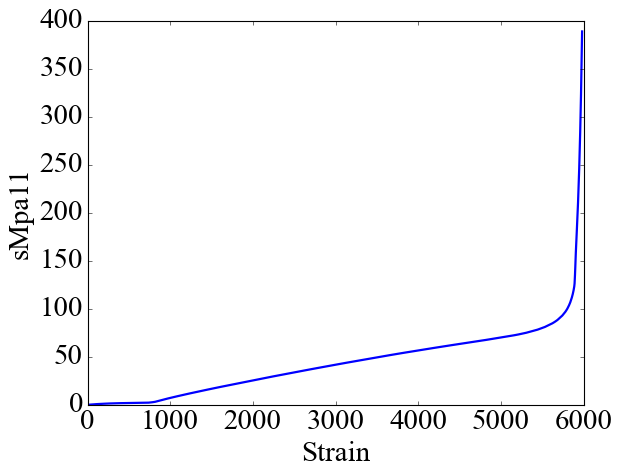

In [18]:
time_ser_1.plot(figsize=(8,6), xlabel='Strain', ylabel=fr"{name_1.split('.')[0]}")
plt.savefig('ts1.jpg', bbox_inches="tight")
plt.show()

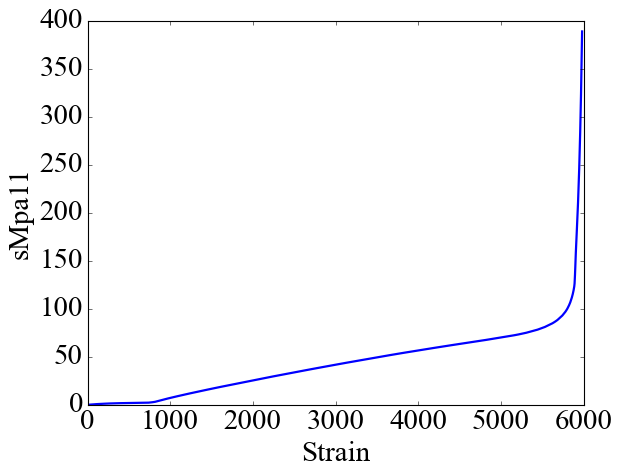

In [19]:
for_graph.plot(figsize=(8,6), xlabel='Strain', ylabel=fr"{name_2.split('.')[0]}")
plt.savefig('ts2.jpg', bbox_inches="tight")
plt.show()

## DFA

### For the whole time series

In [51]:
dfa_time_ser_1 = time_ser_1
ret_type = 4 #вид ряду: 1 - вихідний, 2 - детрендований (різниця між теп. значенням та попереднім)
                        # 3 - прибутковості звичайні, 4 - стандартизовані прибутковості, 5 - абсолютні значення (волатильності)

if ret_type == 1:
    pass
elif ret_type == 2:
    dfa_time_ser_1 = dfa_time_ser_1.diff()
elif ret_type == 3:
    dfa_time_ser_1 = dfa_time_ser_1.pct_change()
elif ret_type == 4:
    dfa_time_ser_1 = dfa_time_ser_1.pct_change()
    dfa_time_ser_1 -= dfa_time_ser_1.mean()
    dfa_time_ser_1 /= dfa_time_ser_1.std()
elif ret_type == 5: 
    dfa_time_ser_1 = dfa_time_ser_1.pct_change()
    dfa_time_ser_1 -= dfa_time_ser_1.mean()
    dfa_time_ser_1 /= dfa_time_ser_1.std()
    dfa_time_ser_1 = dfa_time_ser_1.abs()

dfa_time_ser_1 = dfa_time_ser_1.dropna().values

a = fu.toAggregated(dfa_time_ser_1)

rev = True #Чи повторювати розрахунок ф-ції флуктуацій з кінця
order = 2

pydfa = fathon.DFA(a)

win_beg = 10 #Початкова ширина сегменту
win_end = 2000 #Кінцева ширина сегменту

wins = fu.linRangeByStep(win_beg, win_end)

n, F = pydfa.computeFlucVec(wins, polOrd=order, revSeg=rev)
H, H_intercept = pydfa.fitFlucVec()


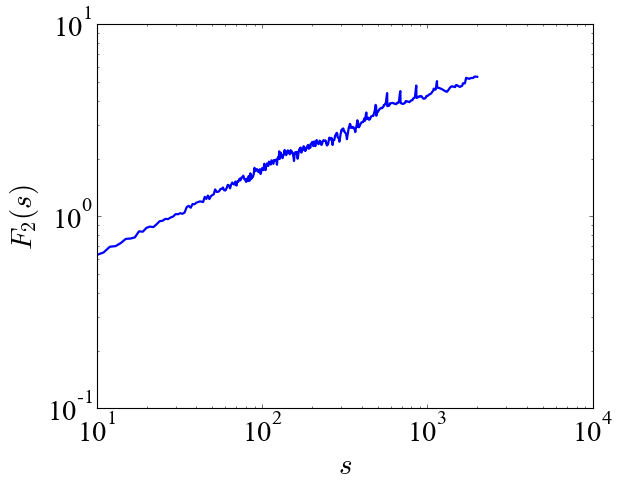

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.loglog(n, F)
ax.set_ylabel(r'$F_{2}(s)$')
ax.set_xlabel(r'$s$')

plt.savefig(f"dfa_F_q_whole_time_series_{name_2.split('.')[0]}_{ret_type}_{order}_{win_beg}_{win_end}.jpg", bbox_inches="tight")
plt.show()

np.savetxt(f"dfa_F_q_whole_time_series_{name_1}_{ret_type}_{order}_{win_beg}_{win_end}.txt", F)

### In window

In [39]:
window = 250 #розмір вікна
tstep = 1 #крок вікна
ret_type = 4 #вид ряду: 1 - вихідний, 2 - детрендований (різниця між теп. значенням та попереднім)
                        # 3 - прибутковості звичайні, 4 - стандартизовані прибутковості, 5 - абсолютні значення (волатильності)

rev = True #Чи повторювати розрахунок ф-ції флуктуацій з кінця
order = 2 #порядок

win_beg = 10 #Початкова ширина сегменту
win_end = window-1 #Кінцева ширина сегменту

length = len(time_ser_1)

h = []
D_f = []

In [40]:
for i in range(0,length-window,tstep):
    fragm_1 = time_ser_1.iloc[i:i+window] #відбираємо фрагмент та в подальшому відбираємо потрібний тип ряду
    if ret_type == 1:
        pass
    elif ret_type == 2:
        fragm_1 = fragm_1.diff()
    elif ret_type == 3:
        fragm_1 = fragm_1.pct_change()
    elif ret_type == 4:
        fragm_1 = fragm_1.pct_change()
        fragm_1 -= fragm_1.mean()
        fragm_1 /= fragm_1.std()
    elif ret_type == 5: 
        fragm_1 = fragm_1.pct_change()
        fragm_1 -= fragm_1.mean()
        fragm_1 /= fragm_1.std()
        fragm_1 = fragm_1.abs()
        
    fragm_1 = fragm_1.dropna().values

    
    a = fu.toAggregated(fragm_1)
    
    pydfa = fathon.DFA(a)

    wins = fu.linRangeByStep(win_beg, win_end-1)

    n, F = pydfa.computeFlucVec(wins, polOrd=order)
    H, H_intercept = pydfa.fitFlucVec()
    D = 2. - H

    h.append(H)
    D_f.append(D)

In [41]:
np.savetxt(f"h_{name_1}_{window}_{tstep}_{ret_type}_{order}_{win_beg}_{win_end}.txt", h)
np.savetxt(f"D_f_{name_1}_{window}_{tstep}_{ret_type}_{order}_{win_beg}_{win_end}.txt", D_f)

In [42]:
h = np.asarray(h).reshape(-1, 1)
D_f = np.asarray(D_f).reshape(-1, 1)
min_max_scaler = preprocessing.MinMaxScaler()

scaled_h = min_max_scaler.fit_transform(h)
scaled_D_f = min_max_scaler.fit_transform(D_f)

scaled_Close_1 = min_max_scaler.fit_transform(time_ser_1.values.reshape(-1, 1)) #нормалізуємо
scaled_for_graph = min_max_scaler.fit_transform(for_graph.values.reshape(-1, 1)) #нормалізуємо

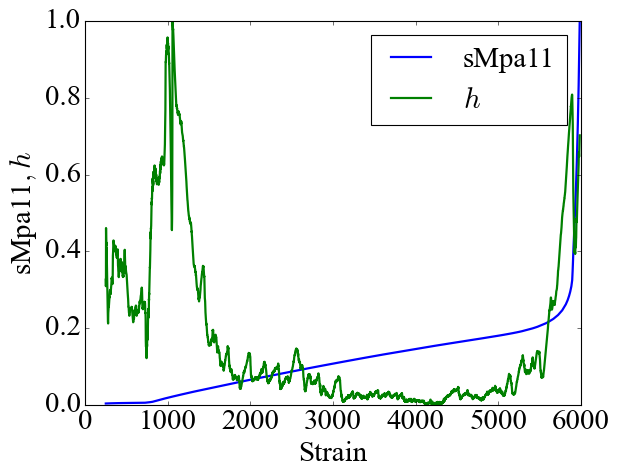

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(time_ser_1.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=fr"{name_2.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_h, label=r"$h$")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{name_2.split('.')[0]}$,$" + "$h$")

plt.savefig(f"h_{name_2.split('.')[0]}_{order}_{window}_{tstep}.jpg", bbox_inches="tight")
plt.show()

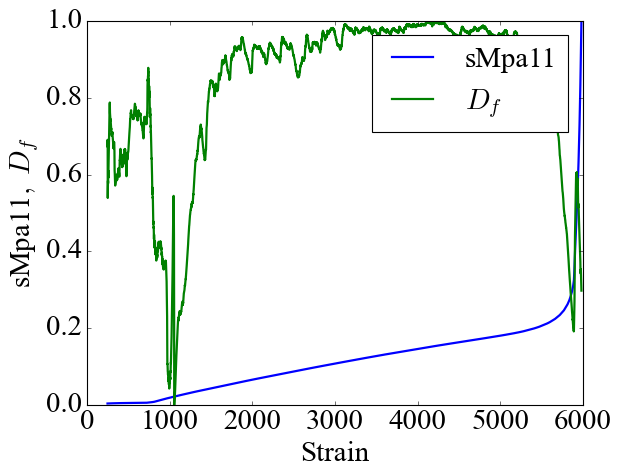

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(time_ser_1.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=fr"{name_2.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_D_f, label="$D_{f}$")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{name_2.split('.')[0]}$,$" + " $D_{f}$")

plt.savefig(f"D_f_{name_2.split('.')[0]}_{order}_{window}_{tstep}.jpg", bbox_inches="tight")
plt.show()

## Fractal Dimensions

In [145]:
window = 250 #розмір вікна
tstep = 5 #крок вікна
ret_type = 4 #вид ряду: 1 - вихідний, 2 - детрендований (різниця між теп. значенням та попереднім)
                        # 3 - прибутковості звичайні, 4 - стандартизовані прибутковості, 5 - абсолютні значення (волатильності)
    

length = len(time_ser_1)

k_max = 20 #For Higuchi. Maximum number of interval times (should be greater than or equal to 2). 
                  #If “default”, then the optimal kmax is computed based 
                  #on the point at which HFD values plateau for a range of kmax values

w_nld = 100            #For FD via Normalized Length Density. 
                  #The duration of the epochs (in samples) by which to cut the signal. Default to 30 samples.

method_petro = "C"      #For Petrosian. Can be ‘A’, ‘B’, ‘C’ or ‘D’. Method ‘A’ binarizes the signal by higher vs. lower values as compated to the signal’s mean. 
                  #Method ‘B’ uses values that are within the mean +/- 1 SD band vs. values that are outside this band. 
                  #Method ‘C’ computes the difference between consecutive samples and binarizes depending on their sign. 
                  #Method ‘D’ forms separates consecutive samples that exceed 1 signal’s SD from the others smaller changes.

method_power_spec = "hasselman2013" #Method to estimate the fractal dimension from the slope, can be ‘voss1988’ (default) or ‘hasselman2013’.            

higuchi_fract = []
katz_fractal = []
nld_fractal = []
petr_fractal = []
psd_fractal = []
sevcik_fractal = []

In [146]:
for i in range(0,length-window,tstep):
    fragm_1 = time_ser_1.iloc[i:i+window] #відбираємо фрагмент та в подальшому відбираємо потрібний тип ряду
    if ret_type == 1:
        pass
    elif ret_type == 2:
        fragm_1 = fragm_1.diff()
    elif ret_type == 3:
        fragm_1 = fragm_1.pct_change()
    elif ret_type == 4:
        fragm_1 = fragm_1.pct_change()
        fragm_1 -= fragm_1.mean()
        fragm_1 /= fragm_1.std()
    elif ret_type == 5: 
        fragm_1 = fragm_1.pct_change()
        fragm_1 -= fragm_1.mean()
        fragm_1 /= fragm_1.std()
        fragm_1 = fragm_1.abs()
        
    fragm_1 = fragm_1.dropna().values
    
    hfd, _ = nk.fractal_higuchi(fragm_1, k_max=k_max, show=False)
    kfd, _ = nk.fractal_katz(fragm_1)
    fnld, _ = nk.fractal_nld(fragm_1, window=w_nld)
    pfd, _ = nk.fractal_petrosian(fragm_1, method=method_petro)
    psdslope, _ = nk.fractal_psdslope(fragm_1, method=method_power_spec, show=False)
    sfd, _ = nk.fractal_sevcik(fragm_1)

    higuchi_fract.append(hfd)
    katz_fractal.append(kfd)
    nld_fractal.append(fnld)
    petr_fractal.append(pfd)
    psd_fractal.append(psdslope)
    sevcik_fractal.append(sfd)

In [147]:
np.savetxt(f"fd_higuchi_{name_1}_{k_max}_{window}_{tstep}.txt", higuchi_fract)
np.savetxt(f"fd_katz_{name_1}_{window}_{tstep}.txt", katz_fractal)
np.savetxt(f"fd_nld_{name_1}_{w_nld}_{window}_{tstep}.txt", nld_fractal)
np.savetxt(f"fd_petrosian_{name_1}_{method_petro}_{window}_{tstep}.txt", petr_fractal)
np.savetxt(f"fd_psd_{name_1}_{method_power_spec}_{window}_{tstep}.txt", psd_fractal)
np.savetxt(f"fd_cevcik_{name_1}_{window}_{tstep}.txt", sevcik_fractal)

In [148]:
hig_fract = np.asarray(higuchi_fract).reshape(-1, 1) #змінюємо форму масива та конвертуємо в масив numpy для нормалізації
kat_fract = np.asarray(katz_fractal).reshape(-1, 1)
norm_len_den_fract = np.asarray(nld_fractal).reshape(-1, 1)
petrosian_fract = np.asarray(petr_fractal).reshape(-1, 1)
power_spec_fract = np.asarray(psd_fractal).reshape(-1, 1)
sevcik_fract = np.asarray(sevcik_fractal).reshape(-1, 1)


min_max_scaler = preprocessing.MinMaxScaler()

scaled_hig_fract = min_max_scaler.fit_transform(hig_fract)
scaled_kat_fract = min_max_scaler.fit_transform(kat_fract)
scaled_norm_len_den_fract = min_max_scaler.fit_transform(norm_len_den_fract)
scaled_petrosian_fract = min_max_scaler.fit_transform(petrosian_fract)
scaled_power_spec_fract = min_max_scaler.fit_transform(power_spec_fract)
scaled_sevcik_fract = min_max_scaler.fit_transform(sevcik_fract)


scaled_time_ser_1 = min_max_scaler.fit_transform(time_ser_1.values.reshape(-1, 1)) #нормалізуємо
scaled_for_graph = min_max_scaler.fit_transform(for_graph.values.reshape(-1, 1)) #нормалізуємо

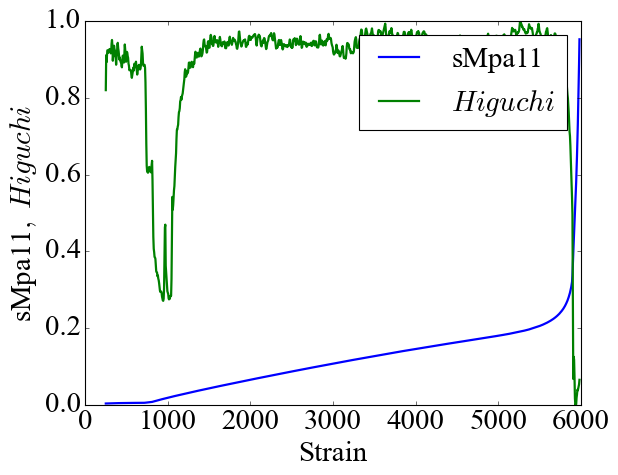

In [149]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(time_ser_1.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=fr"{name_2.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_hig_fract, label=r"$Higuchi$")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{name_2.split('.')[0]}$,$ $Higuchi$")

plt.savefig(f"fd_higuchi_{name_1}_{k_max}_{window}_{tstep}.jpg")
plt.show()

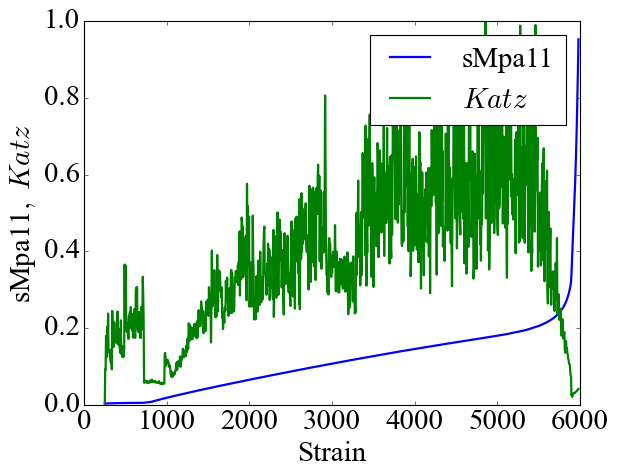

In [150]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(time_ser_1.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=fr"{name_2.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_kat_fract, label=r"$Katz$")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{name_2.split('.')[0]}$,$ $Katz$")

plt.savefig(f"fd_katz_{name_1}_{window}_{tstep}.jpg")
plt.show()

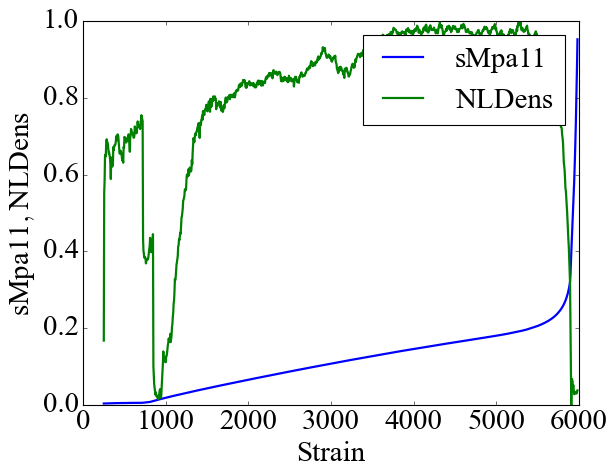

In [151]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(time_ser_1.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=fr"{name_2.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_norm_len_den_fract, label="NLDens")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{name_2.split('.')[0]}$,$" + "NLDens")

plt.savefig(f"fd_nld_{name_1}_{w_nld}_{window}_{tstep}.jpg")
plt.show()

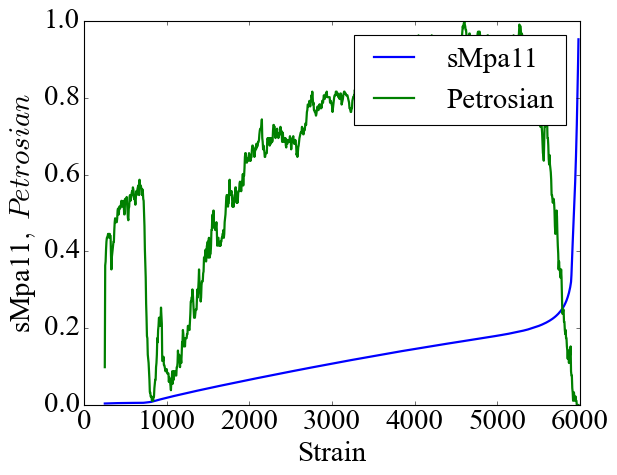

In [152]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(time_ser_1.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=fr"{name_2.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_petrosian_fract, label="Petrosian")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{name_2.split('.')[0]}$,$ $Petrosian$")

plt.savefig(f"fd_petrosian_{name_1}_{method_petro}_{window}_{tstep}.jpg")
plt.show()

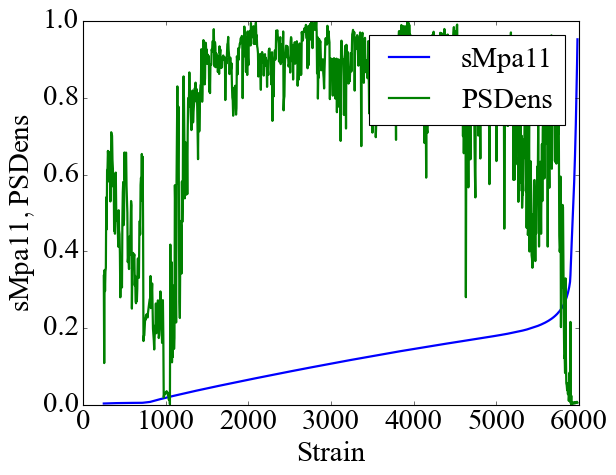

In [153]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(time_ser_1.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=fr"{name_2.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_power_spec_fract, label="PSDens")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{name_2.split('.')[0]}$,$" + "PSDens")

plt.savefig(f"fd_psd_{name_1}_{method_power_spec}_{window}_{tstep}.jpg")
plt.show()

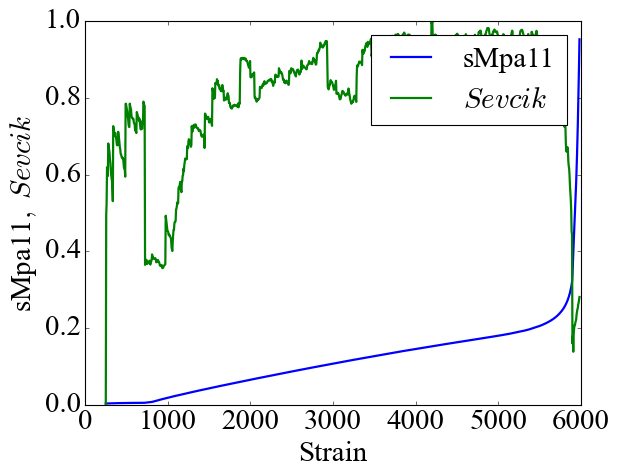

In [154]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(time_ser_1.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=fr"{name_2.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_sevcik_fract, label=r"$Sevcik$")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{name_2.split('.')[0]}$,$ $Sevcik$")

plt.savefig(f"fd_cevcik_{name_1}_{window}_{tstep}.jpg")
plt.show()

## MF-DFA

### For the whole time series

In [97]:
mfdfa_time_ser_1 = time_ser_1
ret_type = 4 #вид ряду: 1 - вихідний, 2 - детрендований (різниця між теп. значенням та попереднім)
                        # 3 - прибутковості звичайні, 4 - стандартизовані прибутковості, 5 - абсолютні значення (волатильності)

if ret_type == 1:
    pass
elif ret_type == 2:
    mfdfa_time_ser_1 = mfdfa_time_ser_1.diff()
elif ret_type == 3:
    mfdfa_time_ser_1 = mfdfa_time_ser_1.pct_change()
elif ret_type == 4:
    mfdfa_time_ser_1 = mfdfa_time_ser_1.pct_change()
    mfdfa_time_ser_1 -= mfdfa_time_ser_1.mean()
    mfdfa_time_ser_1 /= mfdfa_time_ser_1.std()
elif ret_type == 5: 
    mfdfa_time_ser_1 = mfdfa_time_ser_1.pct_change()
    mfdfa_time_ser_1 -= mfdfa_time_ser_1.mean()
    mfdfa_time_ser_1 /= mfdfa_time_ser_1.std()
    mfdfa_time_ser_1 = mfdfa_time_ser_1.abs()

mfdfa_time_ser_1 = mfdfa_time_ser_1.dropna().values

a = fu.toAggregated(mfdfa_time_ser_1)

pymfdfa = fathon.MFDFA(a)

rev = True #Чи повторювати розрахунок ф-ції флуктуацій з кінця

win_beg = 10 #Початкова ширина сегменту
win_end = 3000 #Кінцева ширина сегменту
wins = fu.linRangeByStep(win_beg, win_end)

q_min = -3 #мінімальне значення q
q_max = 3 #максимальне значення q
q_inc = 0.1 #крок збільшення q

q = np.arange(q_min, q_max+q_inc, q_inc, dtype=float)
q = np.round_(q, decimals = 1)

order = 2 #порядок 

n, F = pymfdfa.computeFlucVec(wins, q, revSeg=rev, polOrd=order)
list_H, list_H_intercept = pymfdfa.fitFlucVec()

#compute mass exponents
tau = pymfdfa.computeMassExponents()

#compute multifractal spectrum
alpha, mfSpect = pymfdfa.computeMultifractalSpectrum()

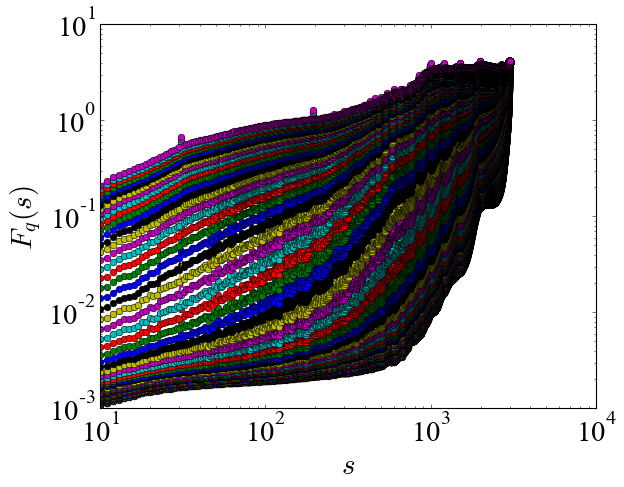

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for i in range(F.shape[0]):
    ax.loglog(n, F[i, :], marker='o', linestyle='dashed')
ax.set_ylabel(r'$F_{q}(s)$')
ax.set_xlabel(r'$s$')

plt.savefig(f"mfdfa_F_q_whole_time_series_{name_2.split('.')[0]}_{ret_type}_{order}_{q_min}_{q_max}_{q_inc}_{win_beg}_{win_end}.jpg", bbox_inches="tight")
plt.show()

np.savetxt(f"mfdfa_F_q_whole_time_series_{name_1}_{ret_type}_{order}_{q_min}_{q_max}_{q_inc}_{win_beg}_{win_end}.txt", F)

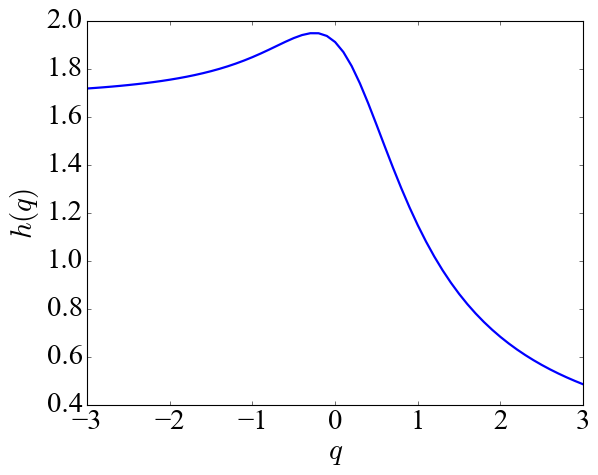

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(q, list_H)
ax.set_ylabel(r'$h(q)$')
ax.set_xlabel(r'$q$')

plt.savefig(f"mfdfa_h_q_whole_time_series_{name_2.split('.')[0]}_{ret_type}_{order}_{q_min}_{q_max}_{q_inc}_{win_beg}_{win_end}.jpg", bbox_inches="tight")
plt.show()

np.savetxt(f"mfdfa_h_q_whole_time_series_{name_1}_{ret_type}_{order}_{q_min}_{q_max}_{q_inc}_{win_beg}_{win_end}.txt", list_H)
np.savetxt(f"mfdfa_q_whole_time_series_{name_1}_{ret_type}_{order}_{q_min}_{q_max}_{q_inc}_{win_beg}_{win_end}.txt", q)

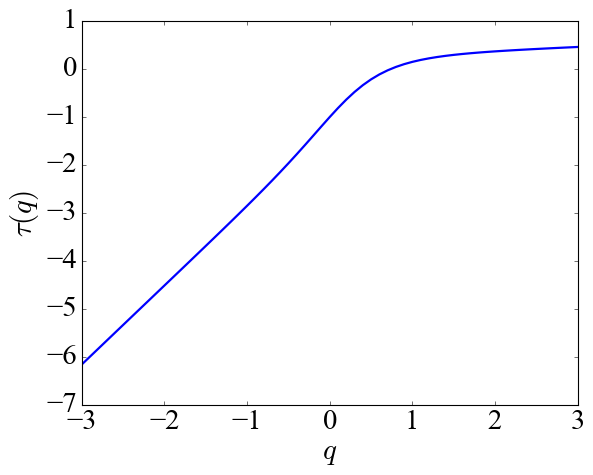

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(q, tau)
ax.set_ylabel(r'$\tau(q)$')
ax.set_xlabel(r'$q$')

plt.savefig(f"mfdfa_tau_q_whole_time_series_{name_2.split('.')[0]}_{ret_type}_{order}_{q_min}_{q_max}_{q_inc}_{win_beg}_{win_end}.jpg", bbox_inches="tight")
plt.show()

np.savetxt(f"mfdfa_tau_q_whole_time_series_{name_1}_{ret_type}_{order}_{q_min}_{q_max}_{q_inc}_{win_beg}_{win_end}.txt", tau)
np.savetxt(f"mfdfa_q_whole_time_series_{name_1}_{ret_type}_{order}_{q_min}_{q_max}_{q_inc}_{win_beg}_{win_end}.txt", q)

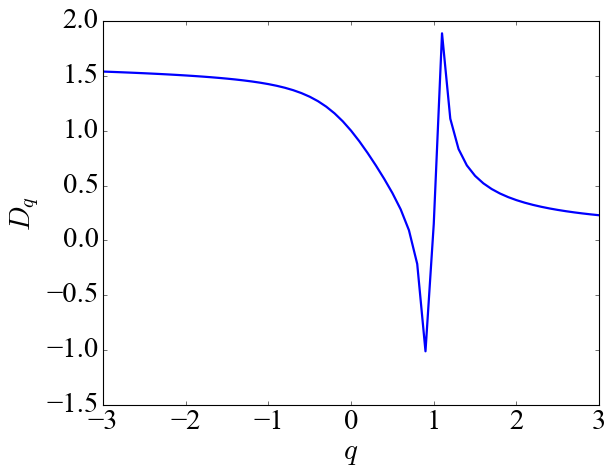

In [101]:
q_0 = np.where(q==0.)[0]
q_1 = np.where(q==1.)[0]
q_2 = np.where(q==2.)[0]
without_one = np.where(q!=1.)[0]
D_Q = np.zeros(len(q))
D_Q[without_one] = tau[without_one]/(q[without_one]-1)
D_Q[q_1] = tau[q_1]
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(q, D_Q)
ax.set_ylabel(r'$D_{q}$')
ax.set_xlabel(r'$q$')

plt.savefig(f"mfdfa_D_q_whole_time_series_{name_2.split('.')[0]}_{ret_type}_{order}_{q_min}_{q_max}_{q_inc}_{win_beg}_{win_end}.jpg", bbox_inches="tight")
plt.show()

np.savetxt(f"mfdfa_D_q_whole_time_series_{name_1}_{ret_type}_{order}_{q_min}_{q_max}_{q_inc}_{win_beg}_{win_end}.txt", D_Q)

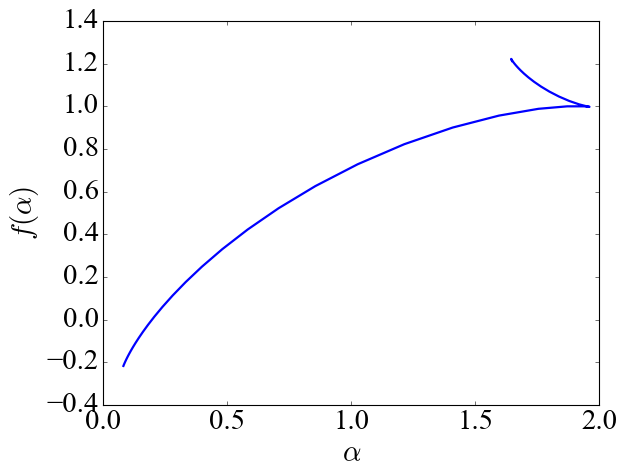

In [102]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(alpha, mfSpect)
ax.set_ylabel(r'$f(\alpha)$')
ax.set_xlabel(r'$\alpha$')

plt.savefig(f"mfdfa_f_alpha_whole_time_series_{name_2.split('.')[0]}_{ret_type}_{order}_{q_min}_{q_max}_{q_inc}_{win_beg}_{win_end}.jpg", bbox_inches="tight")
plt.show()

np.savetxt(f"mfdfa_f_alpha_whole_time_series_{name_1}_{ret_type}_{order}_{q_min}_{q_max}_{q_inc}_{win_beg}_{win_end}.txt", mfSpect)
np.savetxt(f"alpha_whole_time_series_{name_1}_{ret_type}_{order}_{q_min}_{q_max}_{q_inc}_{win_beg}_{win_end}.txt", alpha)

### In window

In [117]:
window = 250 #розмір вікна
tstep = 25 #крок вікна
ret_type = 4 #вид ряду: 1 - вихідний, 2 - детрендований (різниця між теп. значенням та попереднім)
                        # 3 - прибутковості звичайні, 4 - стандартизовані прибутковості, 5 - абсолютні значення (волатильності)
    
rev = True #Чи повторювати розрахунок ф-ції флуктуацій з кінця
q_min = -3 #мінімальне значення q
q_max = 3 #максимальне значення q
q_inc = 1 #крок збільшення q

win_beg = 10 #Початкова ширина сегменту
win_end = window-1 #Кінцева ширина сегменту

length = len(time_ser_1)

q = np.arange(q_min, q_max+q_inc, q_inc)
q = np.round_(q, decimals = 1)


order = 2 #порядок 

delta_alph = []
delta_spec = []
max_alph = []
min_alph = []
mean_alph = []
alpha_zero = []
delta_alph_right = []
delta_alph_left = []
assym = []
delta_s = []
q_sens_values = []
D_0 = []
D_1 = []
D_2 = []

In [118]:
for i in range(0,length-window,tstep):
    fragm_1 = time_ser_1.iloc[i:i+window] #відбираємо фрагмент та в подальшому відбираємо потрібний тип ряду
    
    if ret_type == 1:
        pass
    elif ret_type == 2:
        fragm_1 = fragm_1.diff()
    elif ret_type == 3:
        fragm_1 = fragm_1.pct_change()
    elif ret_type == 4:
        fragm_1 = fragm_1.pct_change()
        fragm_1 -= fragm_1.mean()
        fragm_1 /= fragm_1.std()
    elif ret_type == 5:
        fragm_1 = fragm_1.pct_change()
        fragm_1 -= fragm_1.mean()
        fragm_1 /= fragm_1.std()
        fragm_1 = fragm_1.abs()
    
              
    fragm_1 = fragm_1.dropna().values
    
    a = fu.toAggregated(fragm_1)
    
    pymfdfa = fathon.MFDFA(a)

    wins = fu.linRangeByStep(win_beg, win_end)

    n, F = pymfdfa.computeFlucVec(wins, q, revSeg=rev, polOrd=order)
    list_H, list_H_intercept = pymfdfa.fitFlucVec()

    #compute mass exponents
    tau = pymfdfa.computeMassExponents()

    #compute multifractal spectrum
    alpha, mfSpect = pymfdfa.computeMultifractalSpectrum()
    mfSpect = mfSpect[::-1]
    
    delta_alpha = alpha.max() - alpha.min()
    delta_phi = mfSpect[0] - mfSpect[-1]
    maximal_alpha = alpha.max() 
    minimal_alpha = alpha.min()
    mean_alpha = np.mean(alpha)
    
    idx_alpha_0 = np.argmax(mfSpect)
    alpha_0 = alpha[idx_alpha_0]
    delt_alpha_right = maximal_alpha - alpha_0
    delt_alpha_left = alpha_0 - minimal_alpha
    delt_s = delt_alpha_right - delt_alpha_left
    A = (delt_alpha_left - delt_alpha_right) / (delt_alpha_left + delt_alpha_right)
    
    q_sens = (maximal_alpha-minimal_alpha-maximal_alpha*minimal_alpha)/(maximal_alpha-minimal_alpha)
    
    q_0 = np.where(q==0.)[0]
    q_1 = np.where(q==1.)[0]
    q_2 = np.where(q==2.)[0]
    #without_one = np.where(q!=1.)[0]
    #D_Q = np.zeros(len(q))
    #D_Q[without_one] = tau[without_one]/(q[without_one]-1)
    #D_Q[q_2] = tau[q_2]
    #gen_dim = D_Q[q_0]
    D_zero = mfSpect[q_0]
    D_one = mfSpect[q_1]
    D_two = 2 * alpha[q_2] - mfSpect[q_2]
    
    delta_alph.append(delta_alpha)
    delta_spec.append(delta_phi)
    max_alph.append(maximal_alpha)
    min_alph.append(minimal_alpha)
    mean_alph.append(mean_alpha)
    alpha_zero.append(alpha_0)
    delta_alph_right.append(delt_alpha_right)
    delta_alph_left.append(delt_alpha_left)
    delta_s.append(delt_s)
    assym.append(A)
    q_sens_values.append(q_sens)
    D_0.append(D_zero)
    D_1.append(D_one)
    D_2.append(D_two)

In [119]:
np.savetxt(f"mfdfa_delta_alpha_{name_1}_{order}_{q_min}_{q_max}_{q_inc}_{window}_{tstep}.txt", delta_alph)
np.savetxt(f"mfdfa_delta_f_{name_1}_{order}_{q_min}_{q_max}_{q_inc}_{window}_{tstep}.txt", delta_spec)
np.savetxt(f"mfdfa_max_alpha_{name_1}_{order}_{q_min}_{q_max}_{q_inc}_{window}_{tstep}.txt", max_alph)
np.savetxt(f"mfdfa_min_alpha_{name_1}_{order}_{q_min}_{q_max}_{q_inc}_{window}_{tstep}.txt", min_alph)
np.savetxt(f"mfdfa_mean_alpha_{name_1}_{order}_{q_min}_{q_max}_{q_inc}_{window}_{tstep}.txt", mean_alph)
np.savetxt(f"mfdfa_zero_alpha_{name_1}_{order}_{q_min}_{q_max}_{q_inc}_{window}_{tstep}.txt", alpha_zero)
np.savetxt(f"mfdfa_delta_alpha_right_{name_1}_{order}_{q_min}_{q_max}_{q_inc}_{window}_{tstep}.txt", delta_alph_right)
np.savetxt(f"mfdfa_delta_alpha_left_{name_1}_{order}_{q_min}_{q_max}_{q_inc}_{window}_{tstep}.txt", delta_alph_left)
np.savetxt(f"mfdfa_assymetry_{name_1}_{order}_{q_min}_{q_max}_{q_inc}_{window}_{tstep}.txt", assym)
np.savetxt(f"mfdfa_delta_s_{name_1}_{order}_{q_min}_{q_max}_{q_inc}_{window}_{tstep}.txt", delta_s)
np.savetxt(f"mfdfa_q_sens_{name_1}_{order}_{q_min}_{q_max}_{q_inc}_{window}_{tstep}.txt", q_sens_values)
np.savetxt(f"mfdfa_D_0_{name_1}_{order}_{q_min}_{q_max}_{q_inc}_{window}_{tstep}.txt", D_0)
np.savetxt(f"mfdfa_D_1_{name_1}_{order}_{q_min}_{q_max}_{q_inc}_{window}_{tstep}.txt", D_1)
np.savetxt(f"mfdfa_D_2_{name_1}_{order}_{q_min}_{q_max}_{q_inc}_{window}_{tstep}.txt", D_2)

In [120]:
delta_alpha = np.asarray(delta_alph).reshape(-1, 1) #змінюємо форму масива та конвертуємо в масив numpy для нормалізації
delta_spectral = np.asarray(delta_spec).reshape(-1, 1)
max_alpha = np.asarray(max_alph).reshape(-1, 1)
min_alpha = np.asarray(min_alph).reshape(-1, 1)
mean_alpha = np.asarray(mean_alph).reshape(-1, 1)
alpha_zero = np.asarray(alpha_zero).reshape(-1, 1)
delta_alpha_right = np.asarray(delta_alph_right).reshape(-1, 1)
delta_alpha_left = np.asarray(delta_alph_left).reshape(-1, 1)
delta_s = np.asarray(delta_s).reshape(-1, 1)
assymetry = np.asarray(assym).reshape(-1, 1)
q_sensitive = np.asarray(q_sens_values).reshape(-1, 1)
d_0_val = np.asarray(D_0).reshape(-1, 1)
d_1_val = np.asarray(D_1).reshape(-1, 1)
d_2_val = np.asarray(D_2).reshape(-1, 1)

min_max_scaler = preprocessing.MinMaxScaler()

scaled_delta_alpha = min_max_scaler.fit_transform(delta_alpha)
scaled_spectral = min_max_scaler.fit_transform(delta_spectral)
scaled_max_alpha = min_max_scaler.fit_transform(max_alpha)
scaled_min_alpha = min_max_scaler.fit_transform(min_alpha)
scaled_mean_alpha = min_max_scaler.fit_transform(mean_alpha)
scaled_alpha_zero = min_max_scaler.fit_transform(alpha_zero)
scaled_delta_alpha_right = min_max_scaler.fit_transform(delta_alpha_right)
scaled_delta_alpha_left = min_max_scaler.fit_transform(delta_alpha_left)
scaled_delta_s = min_max_scaler.fit_transform(delta_s)
scaled_assymetry = min_max_scaler.fit_transform(assymetry)
scaled_q_sens = min_max_scaler.fit_transform(q_sensitive)
scaled_D_0 = min_max_scaler.fit_transform(d_0_val)
scaled_D_1 = min_max_scaler.fit_transform(d_1_val)
scaled_D_2 = min_max_scaler.fit_transform(d_2_val)


scaled_time_ser_1 = min_max_scaler.fit_transform(time_ser_1.values.reshape(-1, 1)) #нормалізуємо
scaled_for_graph = min_max_scaler.fit_transform(for_graph.values.reshape(-1, 1)) #нормалізуємо


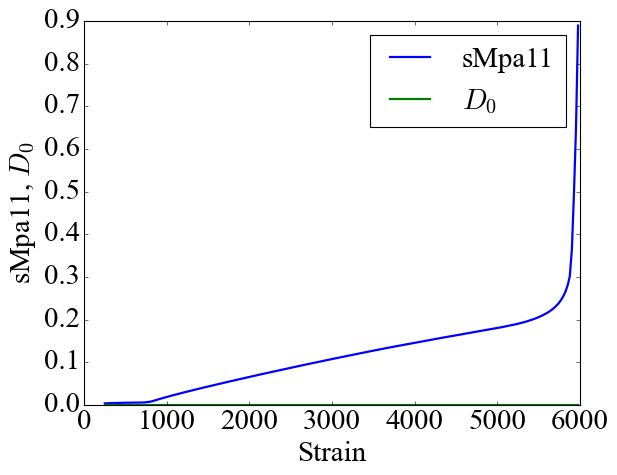

In [127]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(time_ser_1.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=fr"{name_2.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_D_0, label=r"$D_0$")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{name_2.split('.')[0]}, " + r"$D_{0}$")

plt.savefig(f"mfdfa_D_0_{name_2.split('.')[0]}_{order}_{q_min}_{q_max}_{q_inc}_{window}_{tstep}.jpg", bbox_inches="tight")
plt.show()

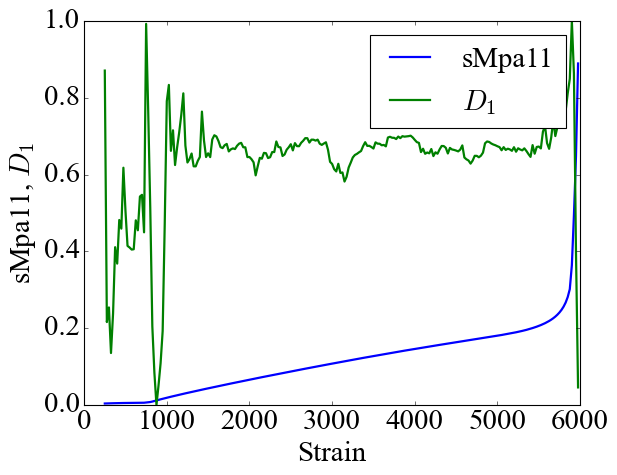

In [128]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(time_ser_1.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=fr"{name_2.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_D_1, label=r"$D_1$")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{name_2.split('.')[0]}, " + r"$D_{1}$")

plt.savefig(f"mfdfa_D_1_{name_2.split('.')[0]}_{order}_{q_min}_{q_max}_{q_inc}_{window}_{tstep}.jpg", bbox_inches="tight")
plt.show()

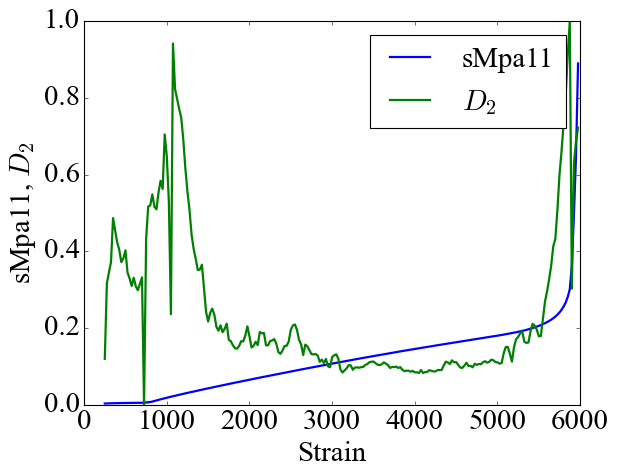

In [129]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(time_ser_1.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=fr"{name_2.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_D_2, label=r"$D_2$")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{name_2.split('.')[0]}, " + r"$D_{2}$")

plt.savefig(f"mfdfa_D_2_{name_2.split('.')[0]}_{order}_{q_min}_{q_max}_{q_inc}_{window}_{tstep}.jpg", bbox_inches="tight")
plt.show()

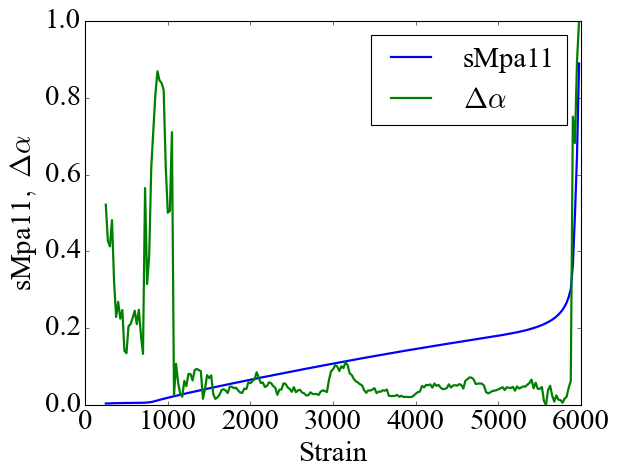

In [121]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(time_ser_1.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=fr"{name_2.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_delta_alpha, label=r"$\Delta\alpha$")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{name_2.split('.')[0]}$,$ $\Delta\alpha$")

plt.savefig(f"mfdfa_delta_alpha_{name_2.split('.')[0]}_{order}_{q_min}_{q_max}_{q_inc}_{window}_{tstep}.jpg")
plt.show()

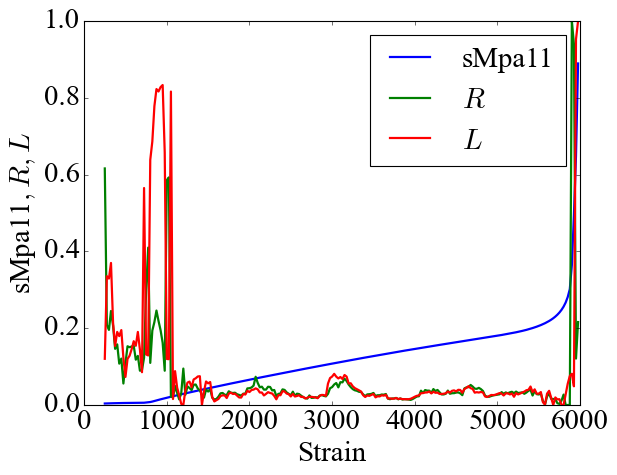

In [122]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(time_ser_1.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=fr"{name_2.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_delta_alpha_right, label=r"$R$")
ax.plot(time_ser_1.index[window:length:tstep], scaled_delta_alpha_left, label=r"$L$")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{name_2.split('.')[0]}$,$" + r"$R, L$")

plt.savefig(f"mfdfa_delta_alpha_left_right_{name_2.split('.')[0]}_{order}_{q_min}_{q_max}_{q_inc}_{window}_{tstep}.jpg", bbox_inches="tight")
plt.show()

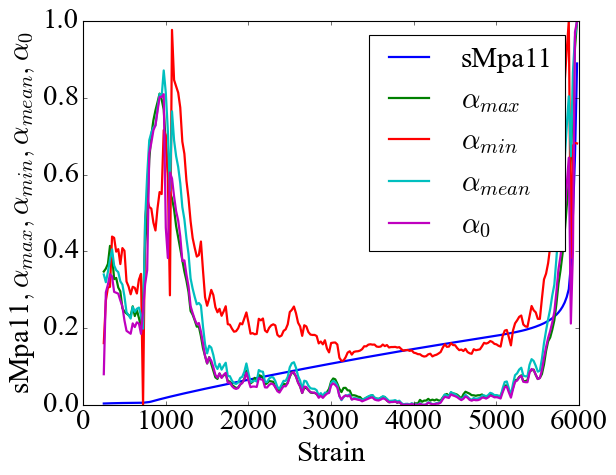

In [123]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(time_ser_1.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=fr"{name_2.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_max_alpha, label=r"$\alpha_{max}$")
ax.plot(time_ser_1.index[window:length:tstep], scaled_min_alpha, label=r"$\alpha_{min}$")
ax.plot(time_ser_1.index[window:length:tstep], scaled_mean_alpha, label=r"$\alpha_{mean}$")
ax.plot(time_ser_1.index[window:length:tstep], scaled_alpha_zero, label=r"$\alpha_{0}$")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{name_2.split('.')[0]}$,$" + r"$\alpha_{max}, \alpha_{min}, \alpha_{mean}, \alpha_{0}$")

plt.savefig(f"mfdfa_alpha_min_max_mean_zero_{name_2.split('.')[0]}_{order}_{q_min}_{q_max}_{q_inc}_{window}_{tstep}.jpg", bbox_inches="tight")
plt.show()

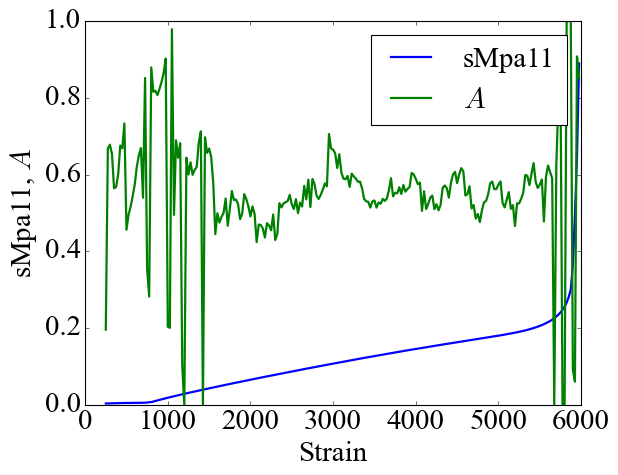

In [124]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(time_ser_1.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=fr"{name_2.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_assymetry, label=r"$A$")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{name_2.split('.')[0]}, " + fr"$A$")

plt.savefig(f"mfdfa_A_{name_2.split('.')[0]}_{order}_{q_min}_{q_max}_{q_inc}_{window}_{tstep}.jpg", bbox_inches="tight")
plt.show()

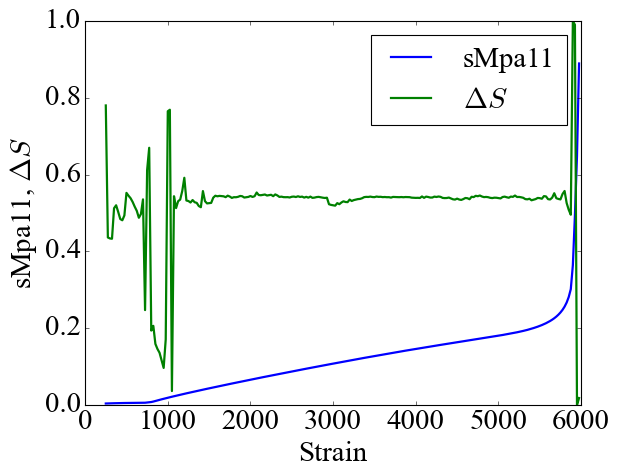

In [125]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(time_ser_1.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=fr"{name_2.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_delta_s, label=r"$\Delta S$")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{name_2.split('.')[0]}, " + fr"$\Delta S$")

plt.savefig(f"mfdfa_delta_S_{name_2.split('.')[0]}_{order}_{q_min}_{q_max}_{q_inc}_{window}_{tstep}.jpg", bbox_inches="tight")
plt.show()

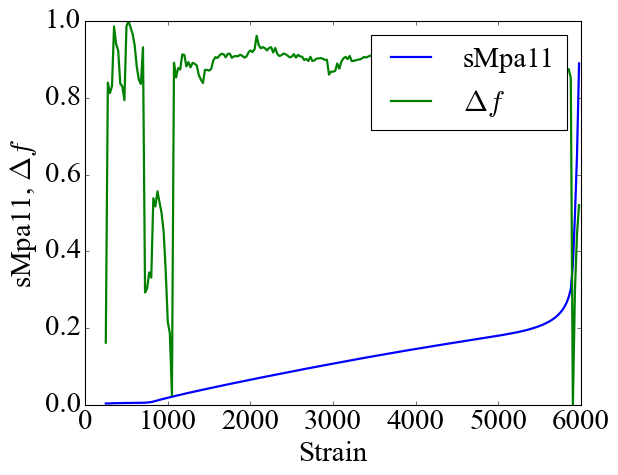

In [126]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(time_ser_1.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=fr"{name_2.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_spectral, label=r"$\Delta f$")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{name_2.split('.')[0]}, " + fr"$\Delta f$")

plt.savefig(f"mfdfa_delta_f_{name_2.split('.')[0]}_{order}_{q_min}_{q_max}_{q_inc}_{window}_{tstep}.jpg", bbox_inches="tight")
plt.show()

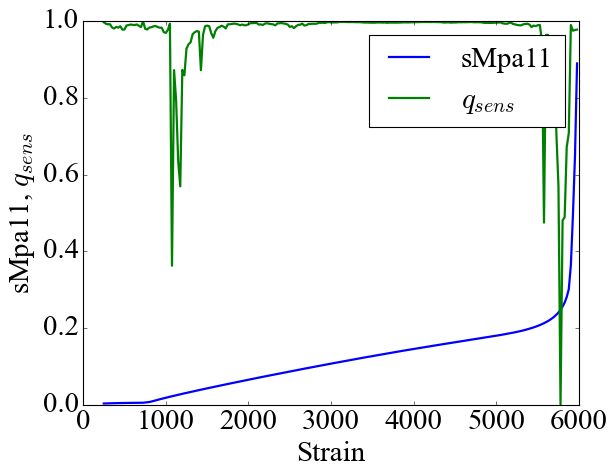

In [130]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(time_ser_1.index[window:length:tstep], scaled_for_graph[window:length:tstep], label=fr"{name_2.split('.')[0]}")
ax.plot(time_ser_1.index[window:length:tstep], scaled_q_sens, label=r"$q_{sens}$")

ax.legend()

ax.set_xlabel("Strain")
ax.set_ylabel(fr"{name_2.split('.')[0]}, " + r"$q_{sens}$")

plt.savefig(f"mfdfa_q_sens_{name_2.split('.')[0]}_{order}_{q_min}_{q_max}_{q_inc}_{window}_{tstep}.jpg", bbox_inches="tight")
plt.show()